In [1]:
# core packages for data analysis
import numpy as np, pandas as pd
import pymc3 as pm
import scipy as sp

In [2]:
from matplotlib import pyplot as plt # core graphing
import seaborn as sns # pretty graphing
%matplotlib inline

David Diaz

# Final Exam

#### Your objective is to determine if daily ambient air pollution levels are associated with cardiovascular mortality. To do so, you will look at data collected from Los Angeles, CA from 1987 to 1997. The variables associated with the data are listed below and the data are available in “LAdata.csv”. Please consider the following in addressing this objective – based on your findings, what is the most important air pollution predictor of death?  
#### Include a brief introduction (1 – 3 sentences), a methods section (with a written description of the model(s) fit, the modeling approach you took, implementation, diagnostics, model selection, etc.), a results, and a short discussion (3-4 sentences that interprets your findings). Tables and figures are welcome.

### Section 1 - Data Exploration

In [3]:
data = pd.read_csv('LAData.csv')

In [4]:
data.head()

,Date,Month,Day of week,season,Deaths,Temp,RelHumid,O3,SO2,NO2,CO
0,1/1/1987,1,5,1,96,57.0000,88.1250,-16.0073,2.8412,26.3063,2436.2
1,1/2/1987,1,6,1,107,57.6250,84.5625,-11.6595,1.1812,27.8281,2011.5
2,1/3/1987,1,7,1,99,58.3750,83.0625,-10.3241,1.1416,11.1614,1215.5
3,1/4/1987,1,1,1,93,54.8750,84.5625,-18.6471,-3.0086,-12.3531,-767.8
4,1/5/1987,1,2,1,97,54.6875,65.1250,-17.5291,-1.4868,-10.2597,145.7


In [5]:
data['Date'] =  pd.to_datetime(data['Date'], format='%m/%d/%Y')

In [6]:
data['Day'] = (data.Date - data.Date[0]).astype('timedelta64[D]')

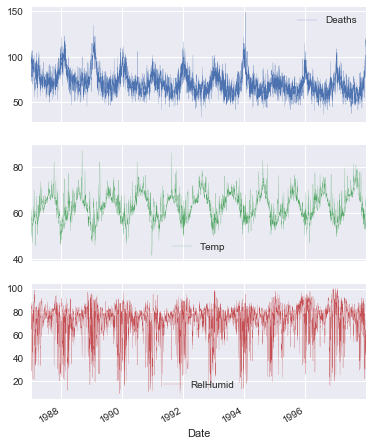

In [7]:
data.plot(x='Date', y=['Deaths', 'Temp', 'RelHumid'], linewidth=0.2, subplots=True, figsize=(6, 8));

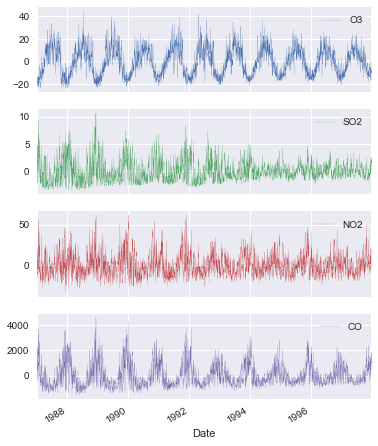

In [8]:
data.plot(x='Date', y=['O3', 'SO2', 'NO2', 'CO'], linewidth=0.2, subplots=True, figsize=(6, 8));

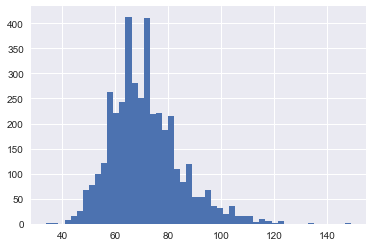

In [9]:
data.Deaths.hist(bins=50);

In [10]:
from pandas.tools.plotting import scatter_matrix

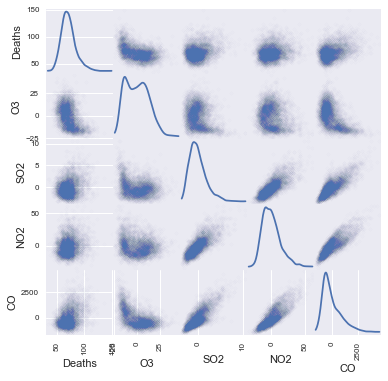

In [11]:
scatter_cols = ['Deaths', 'O3', 'SO2', 'NO2', 'CO']
scatter_matrix(data[scatter_cols], alpha=0.01, figsize=(6, 6), diagonal='kde');

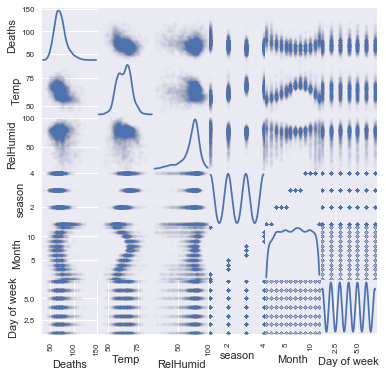

In [12]:
scatter_cols = ['Deaths', 'Temp', 'RelHumid', 'season', 'Month', 'Day of week']
scatter_matrix(data[scatter_cols], alpha=0.01, figsize=(6, 6), diagonal='kde');

### Section 2 - Modest Data Munging

In [13]:
Date = data.Date
Season = data.season
Month = data.Month
DayWeek = data['Day of week']
deaths = data.Deaths

To facilitate MCMC sampling, we'll transform all continuous covariates to z-scores. Temperature and Relative humidity values are still raw values, but pollutant levels came already centered with mean=0.

In [14]:
Temp = data.zTemp = (data.Temp - data.Temp.mean())/data.Temp.std()
RelHum = data.zRelHum = (data.RelHumid - data.RelHumid.mean())/data.RelHumid.std()
O3 = data.zO3 = data.O3/data.O3.std()
SO2 = data.zSO2 = data.SO2/data.SO2.std()
NO2 = data.zNO2 = data.NO2/data.NO2.std()
CO = data.zCO = data.CO/data.CO.std()

In [15]:
# we'll use indexes to estimate parameters for each season, month, and day of week
# -1 used so that indexing list of params starts at 0
season_idx = data.season.values-1
month_idx = data.Month.values-1
dayweek_idx = DayWeek.values-1

In [16]:
num_obs = len(deaths)

### Section 3 - Bayesian Modeling

$y_t \sim Poisson(\mu_t)$  
$log(\mu_t) = \beta_0 + \beta_1Temp_t + \beta_2RelHum_t + \beta_3Season_t + \beta_4Month_t + \beta_5DayofWeek_t + \alpha_1O_3 + \alpha_2SO_2 + \alpha_3NO_2 + \alpha_4CO$

In [17]:
with pm.Model() as pollutant_model:
    
    # priors for unknown model parameters
    b0 = pm.Normal('b0', mu=0, sd=10)
    b1 = pm.Normal('b1', mu=0, sd=10)
    b2 = pm.Normal('b2', mu=0, sd=10)
    b3 = pm.Normal('b3', mu=0, sd=10, shape=4)
    b4 = pm.Normal('b4', mu=0, sd=10, shape=12)
    b5 = pm.Normal('b5', mu=0, sd=10, shape=7)
    a = pm.Normal('a', mu=0, sd=10, shape=4)
        
    # Expected Value of Deaths
    mu_t = pm.math.exp(b0 + b1*Temp + b2*RelHum + b3[season_idx] + b4[month_idx] \
                       + b5[dayweek_idx] + a[0]*O3 + a[1]*SO2 + a[2]*NO2 + a[3]*CO)
    # use of indexes here reaches into the relevant parameter for each variable
    # e.g., b5[dayweek_index] will index into the seven estimated params for b5
    # based on the value of the day of week
    
    # Likelihood
    y_obs = pm.Poisson('y_obs', mu=mu_t, observed=deaths)

In [18]:
# hit the inference button
with pollutant_model:
    # draw a trace with 50,000 posterior samples
    # running chains in parallel with njobs>1 seems to hang
    # so running chains in sequence instead
    trace = pm.backends.base.merge_traces([pm.sample(50000, step=pm.Metropolis(), 
                    chain=i, progressbar=True) for i in range(2)])

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [06:26<00:00, 129.37it/s]


In [ ]:
# hit the inference button
#with parallel_pollutant_model:
#    # draw a trace with 50,000 posterior samples
#    double_trace = pm.sample(draws=1000, step=pm.Metropolis(), njobs=2, progressbar=True)

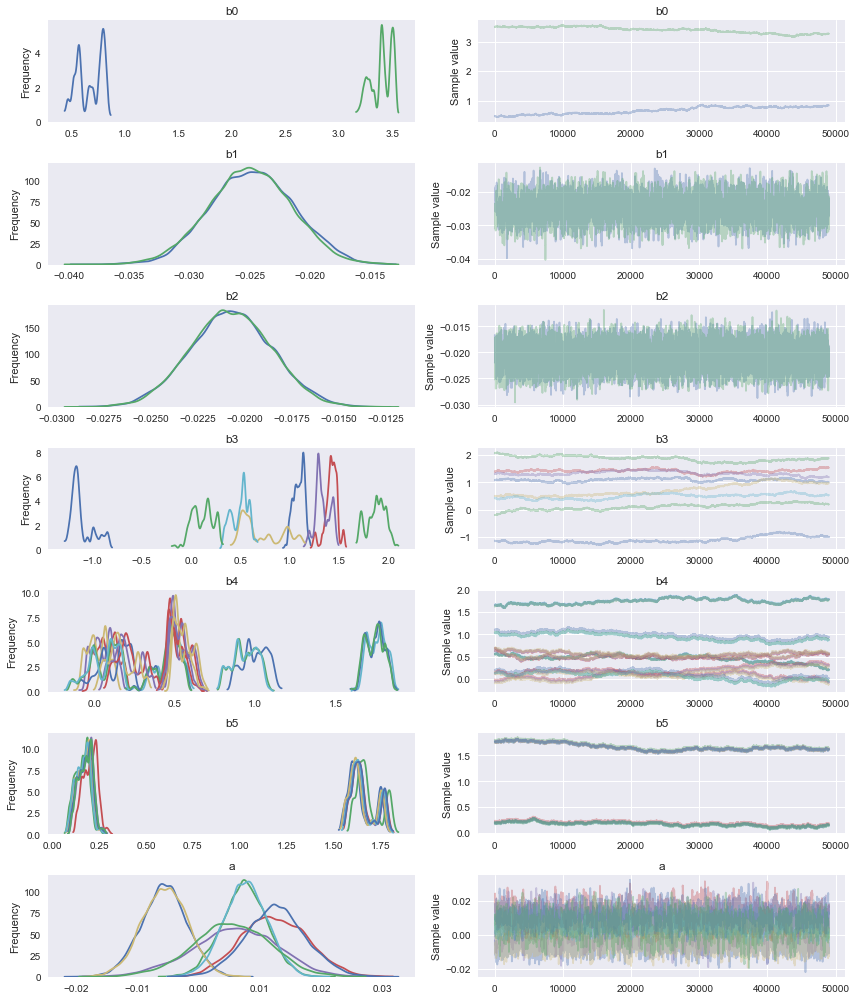

In [27]:
plt.figure()
pm.traceplot(trace[1000:])
plt.tight_layout()

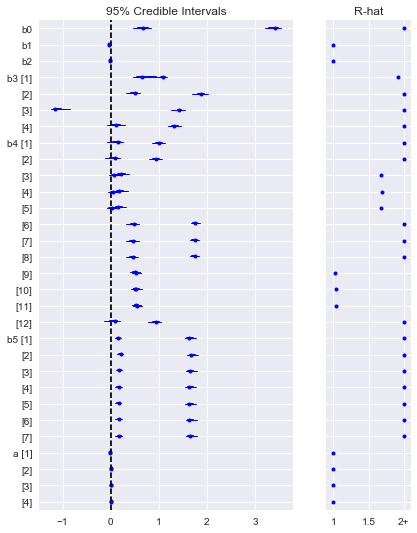

In [30]:
with pollutant_model:
    plt.figure(figsize=(6,8))
    pm.forestplot(trace[1000:])

Visual inspection of chains and Gelman-Rubin $\hat R$ values indicate several parameters are struggling to converge, most notably the intercept ($\beta_0$), season ($\mathbf{\beta_3}$), month ($\mathbf{\beta_4}$), and day of week ($\mathbf{\beta_5}$). Although they haven't converged, the monthly, daily, and seasonal parameters are clustering into groups, suggesting a hierarchical model that pools these parameters would be worth investigating.

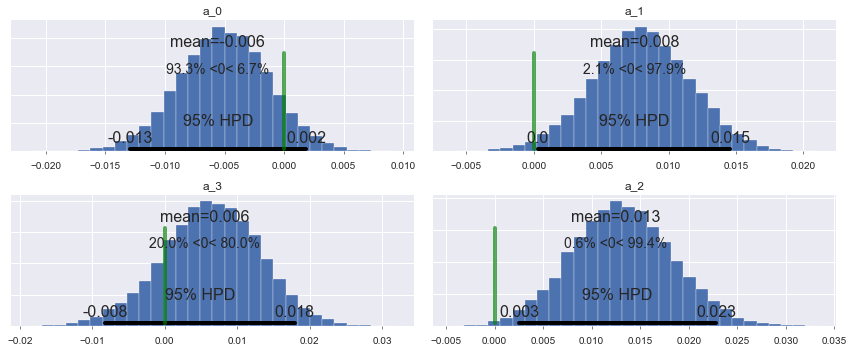

In [31]:
# generate histograms of posterior predictive distributions with  
# 95% highest posterior density intervals and reference line at 0
with pollutant_model:
    # pollutant parameters
    pm.plot_posterior(trace[10000:], varnames=['a'], ref_val=0)

In [ ]:
# statistical assessments of model predictive ability
with pollutant_model:
    pollutant_dic = pm.stats.dic(trace[1000:], model=pollutant_model)
    pollutant_waic = pm.stats.waic(trace[1000:], model=pollutant_modl)
    print(pollutant_dic, pollutant_waic)

In [74]:
# dropping season, with expectation that pooling of month parameters
# will capture seasonal effects
with pm.Model() as hier_model:
    
    # priors for unknown model parameters
    b0 = pm.Normal('b0', mu=0, sd=30)
    b1 = pm.Normal('b1', mu=0, sd=10)
    b2 = pm.Normal('b2', mu=0, sd=10)
    b3_mu = pm.Normal('b3_mu', mu=0, sd=20)
    b3_sd = pm.Uniform('b3_sd', lower=0, upper=1)
    b5_mu = pm.Normal('b5_mu', mu=0, sd=30)
    b5_sd = pm.Uniform('b5_sd', lower=0, upper=1)
    a = pm.Normal('a', mu=0, sd=10, shape=4)
    
    b3 = pm.Normal('b3', mu=0, sd=20, shape=4)
    #b4 = pm.Normal('b4', mu=b4_mu, sd=b4_sd, shape=12)
    b5 = pm.Normal('b5', mu=b5_mu, sd=b5_sd, shape=7)    
       
    # Expected Value of Deaths
    mu_t = pm.math.exp(b0 + b1*Temp + b2*RelHum + b3[season_idx] \
                       + b5[dayweek_idx] + a[0]*O3 + a[1]*SO2 + a[2]*NO2 + a[3]*CO)
    # use of indexes here reaches into the relevant parameter for each variable
    # e.g., b5[dayweek_index] will index into the seven estimated params for b5
    # based on the value of the day of week
    
    # Likelihood
    y_obs = pm.Poisson('y_obs', mu=mu_t, observed=deaths)

In [72]:
# hit the inference button
with hier_model:
    # draw a trace with 50,000 posterior samples
    hier_trace = pm.backends.base.merge_traces([pm.sample(15000, step=pm.Metropolis(), 
                    chain=i, progressbar=True) for i in range(2)])


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [05:22<00:00, 46.58it/s]


In [76]:
# hit the inference button
with hier_model:
    # draw a trace with 5,000 posterior samples
    hier_trace2 = pm.backends.base.merge_traces([pm.sample(5000, init='ADVI', n_init=30000, step=pm.Metropolis(),
                    chain=i, progressbar=True) for i in range(2)])


  0%|                                                                                 | 5/5000 [00:00<01:43, 48.11it/s]

  3%|██▌                                                                            | 159/5000 [00:03<01:31, 52.63it/s]

KeyboardInterrupt: 

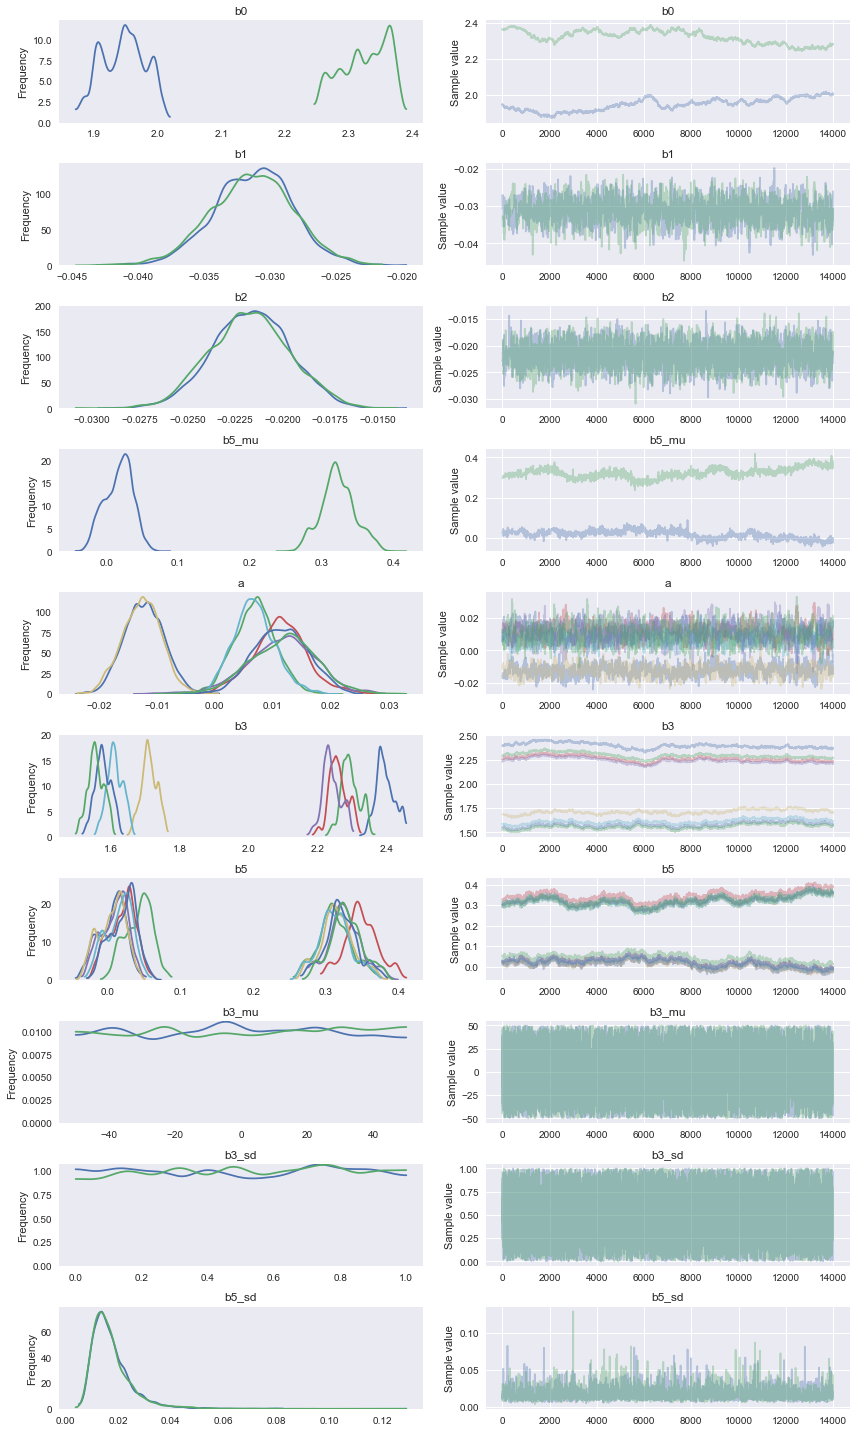

In [73]:
with hier_model:
    plt.figure()
    pm.traceplot(hier_trace2[1000:])
    plt.tight_layout()

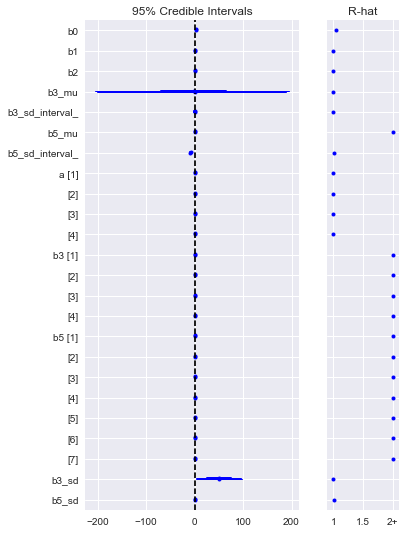

In [52]:
with hier_model:
    plt.figure(figsize=(6,8))
    pm.forestplot(hier_trace[1000:])

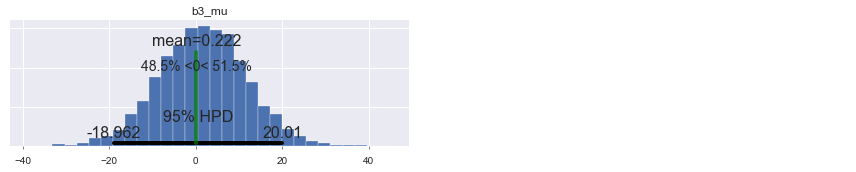

In [67]:
# generate histograms of posterior predictive distributions with  
# 95% highest posterior density intervals and reference line at 0
with hier_model:
    # pollutant parameters
    pm.plot_posterior(hier_trace[1000:], varnames=['b3_mu'], ref_val=0)

In [ ]:
with hier_model:
    hier_dic = (pm.stats.dic(hier_trace[5000:]))
    hier_waic = (pm.stats.waic(hier_trace[5000:]))
    print(hier_dic, hier_waic)

In [63]:
with hier_model:
    print(pm.df_summary(hier_trace[1000:]))

           mean        sd  mc_error    hpd_2.5   hpd_97.5
b0     2.384339  0.151047  0.015090   2.188590   2.626808
b1    -0.031342  0.003044  0.000092  -0.037527  -0.025565
b2    -0.021740  0.002057  0.000051  -0.025804  -0.017841
b3_mu  0.222088  9.992025  0.122240 -18.962275  20.009981
b5_mu  0.988756  0.668776  0.066872   0.267069   1.699624
a__0  -0.012854  0.003310  0.000138  -0.019140  -0.006133
a__1   0.006890  0.003493  0.000136   0.000177   0.013729
a__2   0.011904  0.004735  0.000260   0.002237   0.020788
a__3   0.010822  0.005856  0.000336  -0.001048   0.022093
b3__0  0.986076  0.813041  0.081300   0.056617   1.852980
b3__1  0.886871  0.812897  0.081287  -0.044614   1.748979
b3__2  0.851749  0.812883  0.081285  -0.078554   1.716423
b3__3  0.831536  0.813003  0.081297  -0.098411   1.695978
b5__0  0.977383  0.668683  0.066865   0.258289   1.688390
b5__1  1.013272  0.668723  0.066869   0.288252   1.719030
b5__2  0.991146  0.669133  0.066910   0.265577   1.697927
b5__3  0.98064

In [ ]:
# do partial pooling of monthly (or bi-weekly?) parameter to capture seasonality
# consider smoothing temperature, humidity, and pollutants within 3 prior days to capture cumulative effect

In [ ]:
roll_temp = data.Temp.resample('3D', on=data.Date, label='right', closed='right', how=)
roll_relhum = 
roll_O3 = 
roll_SO2 = 
roll_NO2 = 
roll_CO = 